# This notebook is for creating and running the malaria model for the epi paper

Model adapted from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10733109/

### Load dependencies

In [1]:
import os
import json
import requests
import sympy
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

## Build malaria (host-vector disease) model with MIRA

### Define units

In [ ]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
mosquito_units = lambda: Unit(expression=sympy.Symbol('mosquito'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))

### Define model concepts

In [ ]:
c = {
    # human population
    "Sh": Concept(name="Sh", units=person_units(), identifiers={"ido": "0000514"}),
    "Eh": Concept(name="Eh", units=person_units(), identifiers={"apollosv": "0000154"}),
    "Ih": Concept(name="Ih", units=person_units(), identifiers={"ido": "0000511"}),
    "Rh": Concept(name="Rh", units=person_units(), identifiers={"ido": "0000592"}),
    "Dh": Concept(name="Dh", units=person_units(), identifiers={"ncit": "C28554"}),

    # mosquito population (aquatic stage)
    "G": Concept(name="G", units=mosquito_units()), # eggs
    "L": Concept(name="L", units=mosquito_units()), # larvae
    "P": Concept(name="P", units=mosquito_units()), # pupae

    # mosquito population (adult stage)
    "Sm": Concept(name="Sm", units=mosquito_units()), # susceptible mosquito
    "Em": Concept(name="Em", units=mosquito_units()), # exposed mosquito
    "Im": Concept(name="Im", units=mosquito_units()), # infectious mosquito
}

for concept in c:
    c[concept].name = concept

### Define model parameters with uncertainty

In [ ]:
I0_guess = 15
parameters = {
    # transition rates for human population
    'beta': Parameter(name='beta', value=sympy.Float(0.0043), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.004,
                                                            'maximum': 0.005})),  # Transmission rate Sh -> Ih

    'tr_mult': Parameter(name='tr_mult', value=sympy.Float(1.0), units=dimensionless_units()),  # Transmission reduction multiplier

    'I0': Parameter(name='I0', value=sympy.Float(I0_guess), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.95*I0_guess,
                                                            'maximum': 1.05*I0_guess})),  # Initial value for Ih
    
    'rho': Parameter(name='rho', value=sympy.Float(0.1), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.05,
                                                            'maximum': 0.14})),  # Rate of progressing Eh -> Ih
    
    'gamma': Parameter(name='gamma', value=sympy.Float(0.07), units=per_day_units()),  # Rate of progressing Ih -> Rh

    'mu': Parameter(name='mu', value=sympy.Float(0.0028), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.0025,
                                                            'maximum': 0.003})),  # Death rate Ih -> Dh
    
    'phi': Parameter(name='phi', value=sympy.Float(0.005), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.004,
                                                            'maximum': 0.006})),  # Rate of immunity loss Rh -> Sh
    
    # transition rates for mosquito population 
    'bm': Parameter(name='bm', value=sympy.Float(1.0), units=per_day_units()),  # Per capita oviposition rate of female mosquitoes

    'KG': Parameter(name='KG', value=sympy.Float(15_000), units=per_day_units()),  # Carrying capacity for eggs
    'KL': Parameter(name='KL', value=sympy.Float(10_000), units=per_day_units()),  # Carrying capacity for larvae
    'KP': Parameter(name='KP', value=sympy.Float(7000), units=per_day_units()),  # Carrying capacity for pupae

    'tau': Parameter(name='tau', value=sympy.Float(0.03), units=per_day_units()),  # Hatch rate G -> L
    'nu': Parameter(name='nu', value=sympy.Float(0.005), units=per_day_units()),  # Rate L -> P
    'eps': Parameter(name='eps', value=sympy.Float(0.002), units=per_day_units()),  # Rate P -> Sm

    'dG': Parameter(name='dG', value=sympy.Float(0.028), units=per_day_units()),  # Natural death rate of eggs
    'dL': Parameter(name='dL', value=sympy.Float(0.07), units=per_day_units()),  # Natural death rate of larvae
    'dP': Parameter(name='dP', value=sympy.Float(0.03), units=per_day_units()),  # Natural death rate of pupae
    'eta': Parameter(name='eta', value=sympy.Float(0.011), units=per_day_units()),  # Death rate of adult mosquitoes

    'kappai': Parameter(name='kappai', value=sympy.Float(0.0011), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.001,
                                                            'maximum': 0.0015})),  # Rate Sm -> Im after biting Ih

    'kappar': Parameter(name='kappar', value=sympy.Float(0.02), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.015,
                                                            'maximum': 0.03})),  # Rate Sm -> Im after biting Rh

    'chi': Parameter(name='chi', value=sympy.Float(0.06), units=per_day_units(),
                     distribution=None),  # Rate of progressing Em -> Im

    'zeta': Parameter(name='zeta', value=sympy.Float(0.003), units=per_day_units(),
                 distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.001,
                                                            'maximum': 0.005})),  # Rate at which G, L and P are eliminated by humans
}

### Define `SymPy` variables

In [ ]:
Sh, Eh, Ih, Rh, Dh, G, L, P, Sm, Em, Im, beta, tr_mult, I0, rho, gamma, mu, phi, bm, KG, KL, KP, tau, nu, eps, dG, dL, dP, eta, kappai, kappar, chi, zeta = sympy.symbols(
    'Sh Eh Ih Rh Dh G L P Sm Em Im beta tr_mult I0 rho gamma mu phi bm KG KL KP tau nu eps dG dL dP eta kappai kappar chi zeta')

### Set initial conditions

In [ ]:
initials = {
    "Sh": Initial(concept=c["Sh"], expression=16_000),
    "Eh": Initial(concept=c["Eh"], expression=2*I0_guess),
    "Ih": Initial(concept=c["Ih"], expression=I0),
    "Rh": Initial(concept=c["Rh"], expression=0),
    'Dh': Initial(concept=c["Dh"], expression=0),
    "G": Initial(concept=c["G"], expression=3000),
    "L": Initial(concept=c["L"], expression=800),
    "P": Initial(concept=c["P"], expression=500),
    "Sm": Initial(concept=c["Sm"], expression=300),
    "Em": Initial(concept=c["Em"], expression=50),
    "Im": Initial(concept=c["Im"], expression=20)
}

### Define model templates

In [ ]:
# Human population transitions
##### Sh -> Eh
se = ControlledConversion(
    subject=c['Sh'],
    outcome=c['Eh'],
    controller=c['Im'],
    rate_law=tr_mult*beta*Sh*Im
)


#### Eh -> Ih
ei = NaturalConversion(
    subject=c['Eh'],
    outcome=c['Ih'],
    rate_law=rho*Eh
)


#### Ih -> Rh
ir = NaturalConversion(
    subject=c['Ih'],
    outcome=c['Rh'],
    rate_law=gamma*(1 - mu)*Ih
)


#### Ih -> Dh
id = NaturalConversion(
    subject=c['Ih'],
    outcome=c['Dh'],
    rate_law=gamma*mu*Ih
)

#### Rh -> Sh
rs = NaturalConversion(
    subject=c['Rh'],
    outcome=c['Sh'],
    rate_law=phi*Rh
)

# Mosquito population transitions
#### Mosquito population -> G
mg = GroupedControlledProduction(
    controllers=[c['Sm'], c['Em'], c['Im']],
    outcome=c['G'],
    rate_law=bm*(1 - G/KG)*(Sm + Em + Im)
)


#### G -> L
gl = ControlledConversion(
    subject=c['G'],
    outcome=c['L'],
    controller=c['L'],
    rate_law=tau*(1 - L/KL)*G
)


#### G -> natural death or killed by humans
gd = NaturalDegradation(
    subject=c['G'],
    rate_law=(dG + zeta)*G
)


#### L -> P
lp = ControlledConversion(
    subject=c['L'],
    outcome=c['P'],
    controller=c['P'],
    rate_law=nu*(1 - P/KP)*L
)


#### L -> natural death or killed by humans
ld = NaturalDegradation(
    subject=c['L'],
    rate_law=(dL + zeta)*L
)


#### P -> Sm
psm = NaturalConversion(
    subject=c['P'],
    outcome=c['Sm'],
    rate_law=eps*P
)


#### P -> natural death or killed by humans
pdk = NaturalDegradation(
    subject=c['P'],
    rate_law=(dP + zeta)*P
)


### Sm -> Em
smem = GroupedControlledConversion(
    controllers=[c['Ih'], c['Rh']],
    subject=c['Sm'],
    outcome=c['Em'],
    rate_law=tr_mult*kappai*Sm*Ih + tr_mult*kappar*Sm*Rh
)


#### Sm -> natural death or killed by humans
smd = NaturalDegradation(
    subject=c['Sm'],
    rate_law=(eta + zeta)*Sm
)


#### Em -> Im
emim = NaturalConversion(
    subject=c['Em'],
    outcome=c['Im'],
    rate_law=chi*Em
)


#### Em -> natural death or killed by humans
emd = NaturalDegradation(
    subject=c['Em'],
    rate_law=(eta + zeta)*Em
)


#### Im -> natural death or killed by humans
imd = NaturalDegradation(
    subject=c['Im'],
    rate_law=(eta + zeta)*Im
)

### Define observables

In [ ]:
observables_seir = {
    'infected_humans': Observable(name='infected_humans', expression=Ih),
    'deceased_humans': Observable(name='deceased_humans', expression=Dh),
    'infected_mosquitoes': Observable(name='infected_mosquitoes', expression=Im),
    'aquatic_mosquitoes': Observable(name='aquatic_mosquitoes', expression=G+L+P),
    'adult_mosquitoes': Observable(name='adult_mosquitoes', expression=Sm+Em+Im),
}

### Define template model and save as a petrinet AMR

In [ ]:
malaria_model = TemplateModel(
    templates=[
        se,
        ei,
        ir,
        id,
        rs,
        mg,
        gl,
        gd,
        lp,
        ld,
        psm,
        pdk,
        smem,
        smd,
        emim,
        emd,
        imd
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables_seir,
    annotations=Annotations(name='Malaria base model')
)

# Save as JSON
with open("malaria_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(malaria_model), fh, indent=1)

## Run the model with PyCIEMSS

### Set model path and parameters for sampling

In [2]:
model = "malaria_model.json"
num_samples = 10
start_time = 0.0
end_time = 40.0
logging_step_size = 1.0

### Sample from model prior distribution and plot the results

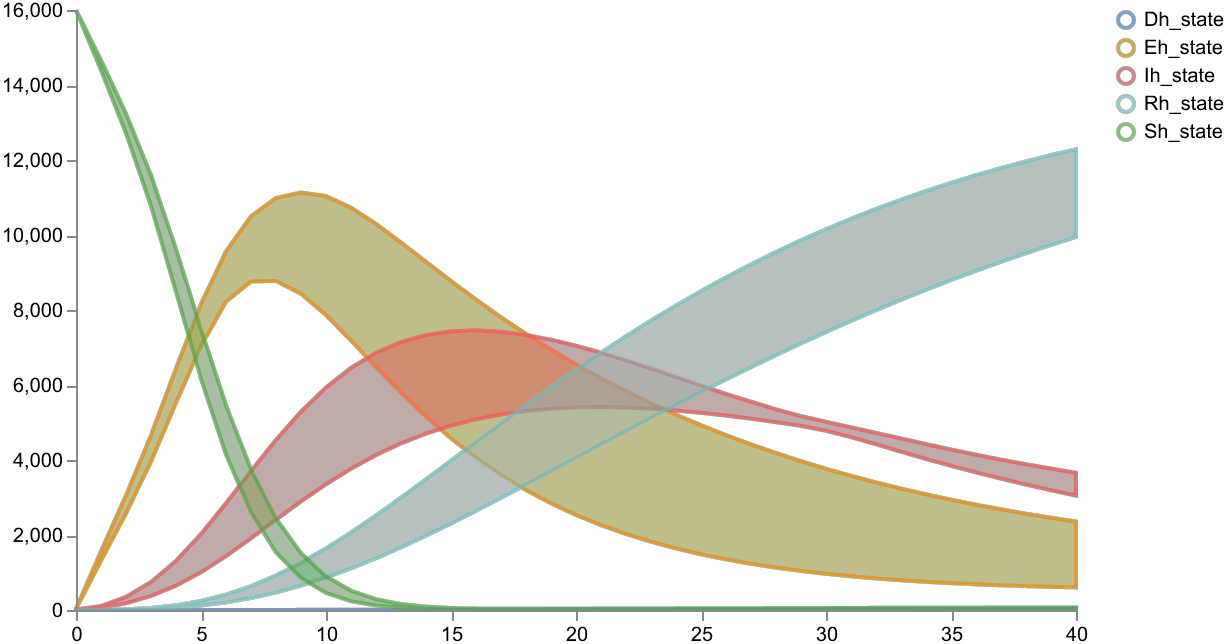

In [3]:
result = pyciemss.sample(model, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for human states
schema = plots.trajectories(result["data"], keep=".*h_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

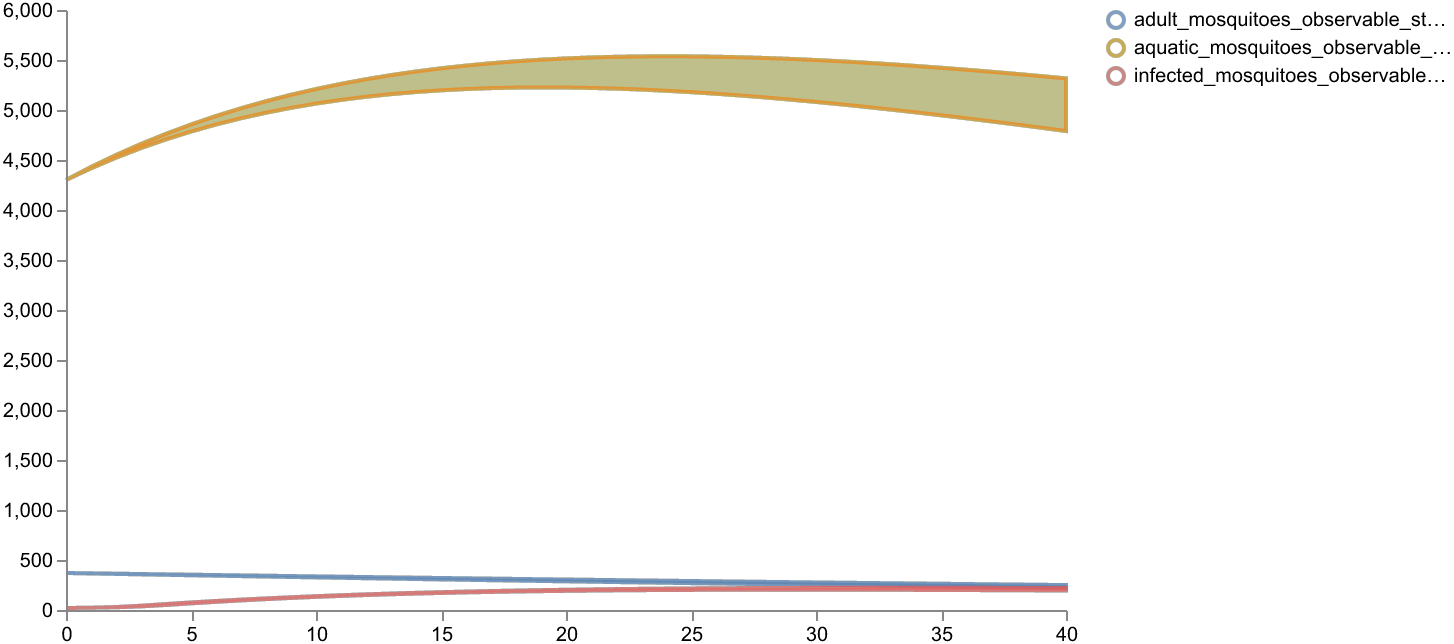

In [4]:
# Plot results for mosquito states
schema = plots.trajectories(result["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Create synthetic data

### Remove uncertainty in the transmission rate `beta` and the death rate `mu`

In [ ]:
print(f"beta value: {malaria_model.parameters['beta'].value}")
print(f"beta prior distribution: {malaria_model.parameters['beta'].distribution}")
malaria_model.parameters['beta'].distribution = None

print(f"mu value: {malaria_model.parameters['mu'].value}")
print(f"mu prior distribution: {malaria_model.parameters['mu'].distribution}")
malaria_model.parameters['mu'].distribution = None

# Save as updated AMR
with open('malaria_model_const_beta_mu.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(malaria_model), fh, indent=1)

### Take a single sample of the updated model

In [ ]:
mod_model = 'malaria_model_const_beta_mu.json'
result1 = pyciemss.sample(mod_model, end_time, logging_step_size, 1, start_time=start_time)
# display(result1['data'].head())

# # Plot results for human states
# schema = plots.trajectories(result1["data"], keep=".*h_state")
# plots.save_schema(schema, "_schema.json")
# plots.ipy_display(schema, dpi=150)

In [ ]:
print(result1['data'])

In [ ]:
mod_model = 'malaria_model_const_beta_mu.json'
result2 = pyciemss.sample(mod_model, end_time, logging_step_size, 1, start_time=start_time)
print(result2['data'])

In [ ]:
mod_model = 'malaria_model_const_beta_mu.json'
result3 = pyciemss.sample(mod_model, end_time, logging_step_size, 1, start_time=start_time)
print(result3['data'])

In [ ]:
mod_model = 'malaria_model_const_beta_mu.json'
result4 = pyciemss.sample(mod_model, end_time, logging_step_size, 1, start_time=start_time)
print(result4['data'])

In [ ]:
mod_model = 'malaria_model_const_beta_mu.json'
result5 = pyciemss.sample(mod_model, end_time, logging_step_size, 1, start_time=start_time)
print(result5['data'])

In [ ]:
mod_model = 'malaria_model_const_beta_mu.json'
result6 = pyciemss.sample(mod_model, end_time, logging_step_size, 1, start_time=start_time)
print(result6['data'])

### Add Gaussian and uniformly distributed noise to the simulated result

In [ ]:
# Uniform noise: U(0.9 * value, 1.1 * value)
df_uniform = result1['data'].copy()
df_uniform['Ih_state'] = df_uniform['Ih_state'] * np.random.uniform(0.9, 1.1, df_uniform['Ih_state'].shape)
df_uniform['Dh_state'] = df_uniform['Dh_state'] * np.random.uniform(0.9, 1.1, df_uniform['Dh_state'].shape)

# Make sure all values are positive and round to nearest decimal
df_uniform['Ih_state'] = df_uniform['Ih_state'].abs().round(1)
df_uniform['Dh_state'] = df_uniform['Dh_state'].abs().round(1)

# Keep data to time 14
df_uniform = df_uniform.iloc[:15]

# Create the new dataframe for uniform noise
uniform_df = pd.DataFrame({
    'Timestamp': df_uniform['timepoint_unknown'],
    'Ih_data': df_uniform['Ih_state'],
    'Dh_data': df_uniform['Dh_state']
})

# Gaussian noise: N(mean = value, standard_deviation = 0.1 * value)
df_gaussian = result1['data'].copy()
df_gaussian['Ih_state'] = df_gaussian['Ih_state'] + np.random.normal(0, 0.1 * df_gaussian['Ih_state'], df_gaussian['Ih_state'].shape)
df_gaussian['Dh_state'] = df_gaussian['Dh_state'] + np.random.normal(0, 0.1 * df_gaussian['Dh_state'], df_gaussian['Dh_state'].shape)

# Make sure all values are positive and round to nearest decimal
df_gaussian['Ih_state'] = df_gaussian['Ih_state'].abs().round(1)
df_gaussian['Dh_state'] = df_gaussian['Dh_state'].abs().round(1)

# Keep data to time 14
df_gaussian = df_gaussian.iloc[:15]

# Create the new dataframe for Gaussian noise
gaussian_df = pd.DataFrame({
    'Timestamp': df_gaussian['timepoint_unknown'],
    'Ih_data': df_gaussian['Ih_state'],
    'Dh_data': df_gaussian['Dh_state']
})

# Save synthetic data
# uniform_df.to_csv('synth_data_unif.csv', index=False)
# gaussian_df.to_csv('synth_data_gaussian.csv', index=False)

## Calibrate the original model to the synthetically generated data

In [5]:
noise_pref = "uniform"

data_mapping = {'Ih_data': 'Ih', 'Dh_data': 'Dh'}
num_iterations = 50

if noise_pref == "gauss":
    dataset = "synth_data_gaussian.csv"
else:
    dataset = "synth_data_unif.csv"
    
calibrated_result = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_result["inferred_parameters"]
    
display(parameter_estimates())
    
calibrated_sample_result = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, inferred_parameters=parameter_estimates)

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 14 rows of data. The first column, Timestamp, begins at 0.0 and ends at 14.0. The subsequent columns are named: Ih_data, Dh_data


{'persistent_beta': tensor(0.0044, grad_fn=<ExpandBackward0>),
 'persistent_rho': tensor(0.0976, grad_fn=<ExpandBackward0>),
 'persistent_mu': tensor(0.0027, grad_fn=<ExpandBackward0>),
 'persistent_phi': tensor(0.0050, grad_fn=<ExpandBackward0>),
 'persistent_zeta': tensor(0.0024, grad_fn=<ExpandBackward0>),
 'persistent_kappai': tensor(0.0013, grad_fn=<ExpandBackward0>),
 'persistent_kappar': tensor(0.0225, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(15.1251, grad_fn=<ExpandBackward0>)}

### Plot the result

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_rho_param,persistent_mu_param,persistent_phi_param,persistent_zeta_param,persistent_kappai_param,persistent_kappar_param,...,Em_state,Sm_state,G_state,L_state,P_state,infected_humans_observable_state,deceased_humans_observable_state,infected_mosquitoes_observable_state,aquatic_mosquitoes_observable_state,adult_mosquitoes_observable_state
0,0,0,0.0,0.004407,0.098215,0.002718,0.004661,0.002852,0.00131,0.024842,...,50.000000,300.000000,3000.000000,800.000000,500.000000,14.859945,0.000000,20.000000,4300.000000,370.000000
1,1,0,1.0,0.004407,0.098215,0.002718,0.004661,0.002852,0.00131,0.024842,...,66.930138,275.953644,3114.270996,821.483704,486.577240,83.047989,0.007257,23.006042,4422.332031,365.889832
2,2,0,2.0,0.004407,0.098215,0.002718,0.004661,0.002852,0.00131,0.024842,...,150.874161,182.147873,3216.547363,844.023865,473.722504,274.460266,0.039398,28.788033,4534.293945,361.810059
3,3,0,3.0,0.004407,0.098215,0.002718,0.004661,0.002852,0.00131,0.024842,...,263.571075,53.233624,3307.876709,867.217529,461.420685,585.683533,0.119271,40.956783,4636.515137,357.761475
4,4,0,4.0,0.004407,0.098215,0.002718,0.004661,0.002852,0.00131,0.024842,...,292.697693,3.634332,3389.212891,890.723022,449.654602,1027.040894,0.270582,57.412590,4729.590820,353.744629


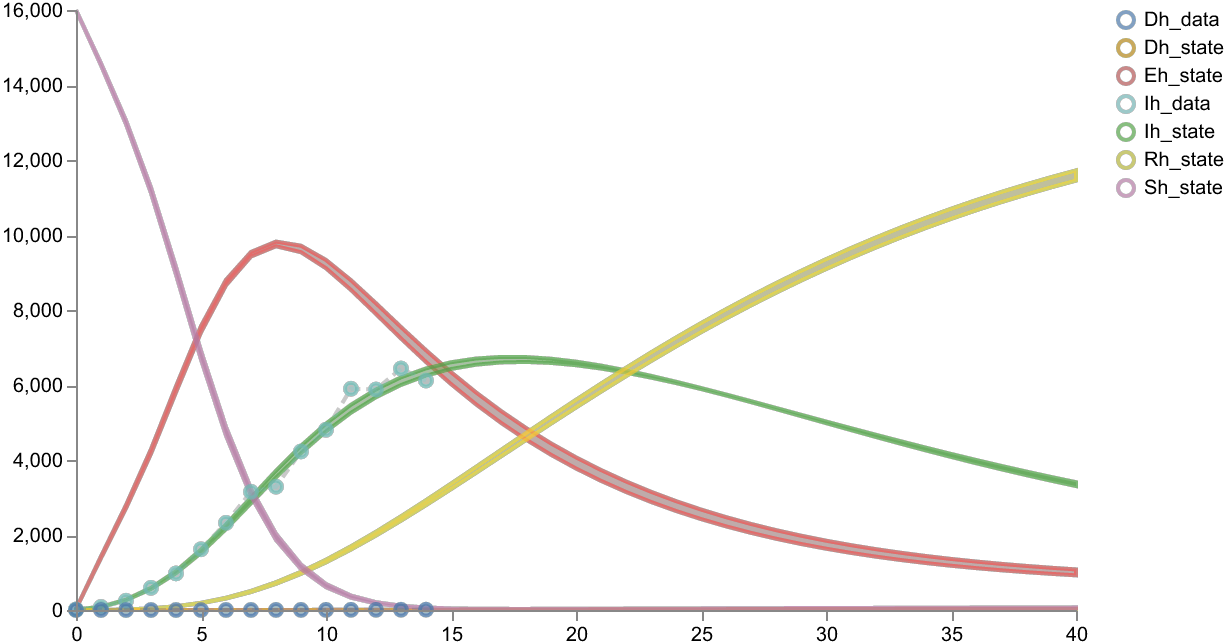

In [6]:
display(calibrated_sample_result['data'].head())

# Plot results for human states
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    calibrated_sample_result["data"], 
    keep=".*h_state", 
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot prior and calibrated parameter distributions

/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


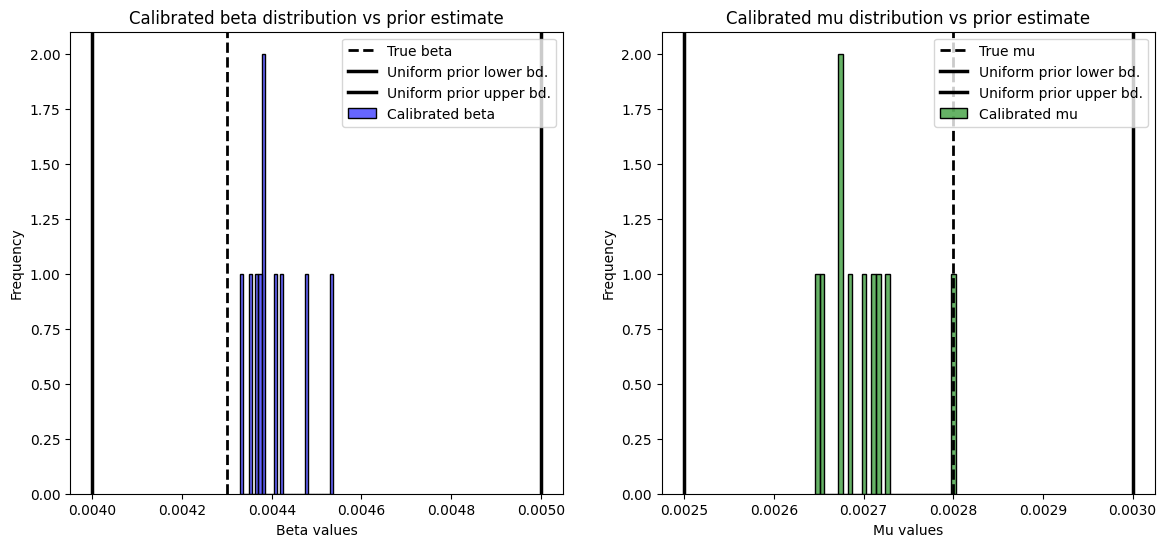

In [7]:
# Extract unique `persistent_beta_param` values
unique_beta_params = calibrated_sample_result['data'][['sample_id', 'persistent_beta_param']].drop_duplicates()['persistent_beta_param']
unique_mu_params = calibrated_sample_result['data'][['sample_id', 'persistent_mu_param']].drop_duplicates()['persistent_mu_param']

# Set up the plotting grid
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of beta values
sns.histplot(unique_beta_params, kde=False, color='blue', bins=30, label='Calibrated beta', alpha=0.6, ax=axs[0])
axs[0].axvline(x=0.0043, color='black', linestyle='--', linewidth=2, label='True beta')
axs[0].axvline(x=0.004, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[0].axvline(x=0.005, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[0].set_xlabel('Beta values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Calibrated beta distribution vs prior estimate')
axs[0].legend()

# Histogram of mu values
sns.histplot(unique_mu_params, kde=False, color='green', bins=30, label='Calibrated mu', alpha=0.6, ax=axs[1])
axs[1].axvline(x=0.0028, color='black', linestyle='--', linewidth=2, label='True mu')
axs[1].axvline(x=0.0025, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[1].axvline(x=0.003, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[1].set_xlabel('Mu values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Calibrated mu distribution vs prior estimate')
axs[1].legend()

# Show plot
plt.show()

## Intervene on the model

### Decrease contact between humans and mosquitoes by 50% at time `t = 5`

In [ ]:
intervened_sample_results1 = pyciemss.sample(
    model, end_time, logging_step_size, num_samples, start_time=start_time, 
    inferred_parameters=parameter_estimates,
    static_parameter_interventions = {torch.tensor(5.0): {"tr_mult": torch.tensor(0.5)}}
)

# Plot results for human states
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep=".*h_state", 
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# Plot results for mosquito states
schema = plots.trajectories(intervened_sample_results1["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Increase the death rate of mosquitoes by insecticide to 10% at time `t = 5`

In [ ]:
intervened_sample_results2 = pyciemss.sample(
    model, end_time, logging_step_size, num_samples, start_time=start_time, 
    inferred_parameters=parameter_estimates,
    static_parameter_interventions = {torch.tensor(5.0): {"zeta": torch.tensor(0.1)}}
)

# Plot results for human states
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    intervened_sample_results2["data"], 
    keep=".*h_state", 
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# Plot results for mosquito states
schema = plots.trajectories(intervened_sample_results2["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Find the optimal intervention to keep malaria infections below 7,000

### Set up optimization and define QoI

In [8]:
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi

num_samples_ouu = 100 # controls accuracy of risk estimation in each optimization iteration
maxiter = 5 # maximum number of restarts of local convex optimizer leading to maxiter + 1 local optimizations
maxfeval = 30 # maximum number of function evaluations in each instance of local convex optimization

### Perform optimization for reduction in transmission

In [9]:
# Define optimization problem setup
observed_params = ["Ih_state"]
intervention_time = [torch.tensor(5.0)]
intervened_params = ["tr_mult"]
current_param_value = 0.99
initial_guess_interventions = 0.75
bounds_interventions = [[0.1], [1.0]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

# # Get infections below 2000 by end of simulation
# risk_bound = 2000.0
# qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)

# Keep infections below 6000
risk_bound = 6000.0
qoi = lambda y: obs_max_qoi(y, observed_params)

objfun = lambda x: -x # np.abs(current_param_value - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

Optimal policy: tensor([0.2105], dtype=torch.float64)
{'policy': tensor([0.2105], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -0.2104300859482532
                          x: [ 2.105e-01]
                        nit: 5
      minimization_failures: 4
                       nfev: 54
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -0.2104300859482532
                                   x: [ 2.104e-01]
                                nfev: 8
                               maxcv: 0.0}


### Sample with optimal intervention applied

Intervention:  {5.0: {'tr_mult': tensor([0.2105])}}
Risk associated with QoI: [3708.80615234375]


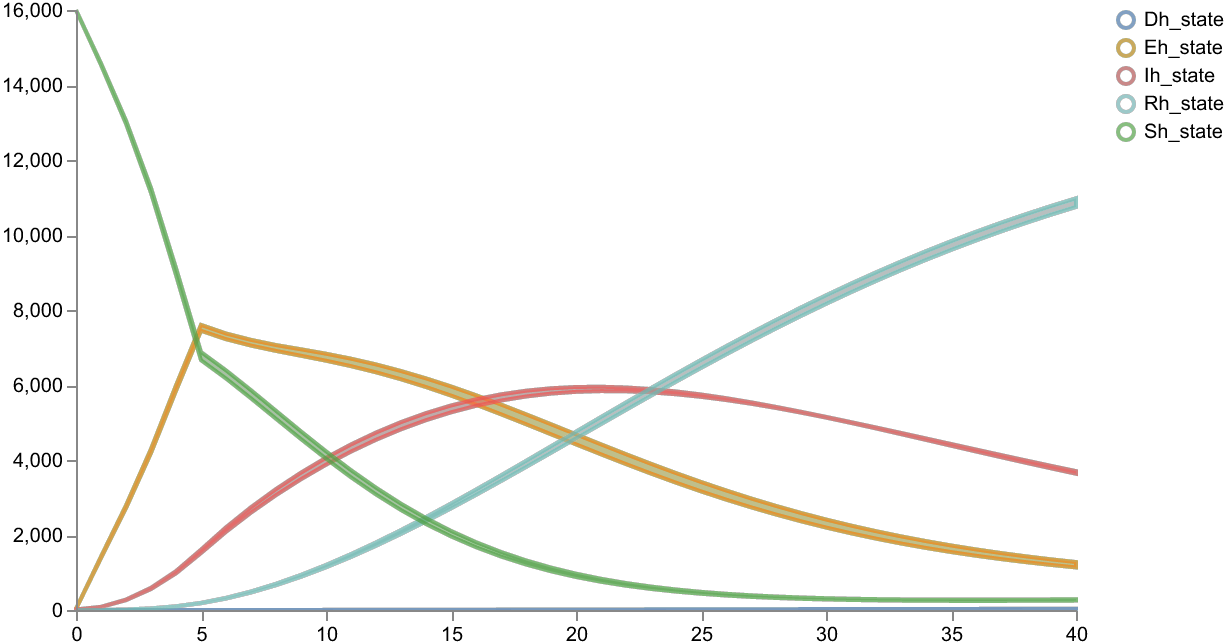

In [10]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))

opt_intervention_result1 = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
)

# display(result1["data"])
print("Risk associated with QoI:", opt_intervention_result1["risk"][observed_params[0]]["risk"])

# Plot results for human states
schema = plots.trajectories(
    opt_intervention_result1["data"], 
    keep=".*h_state", 
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

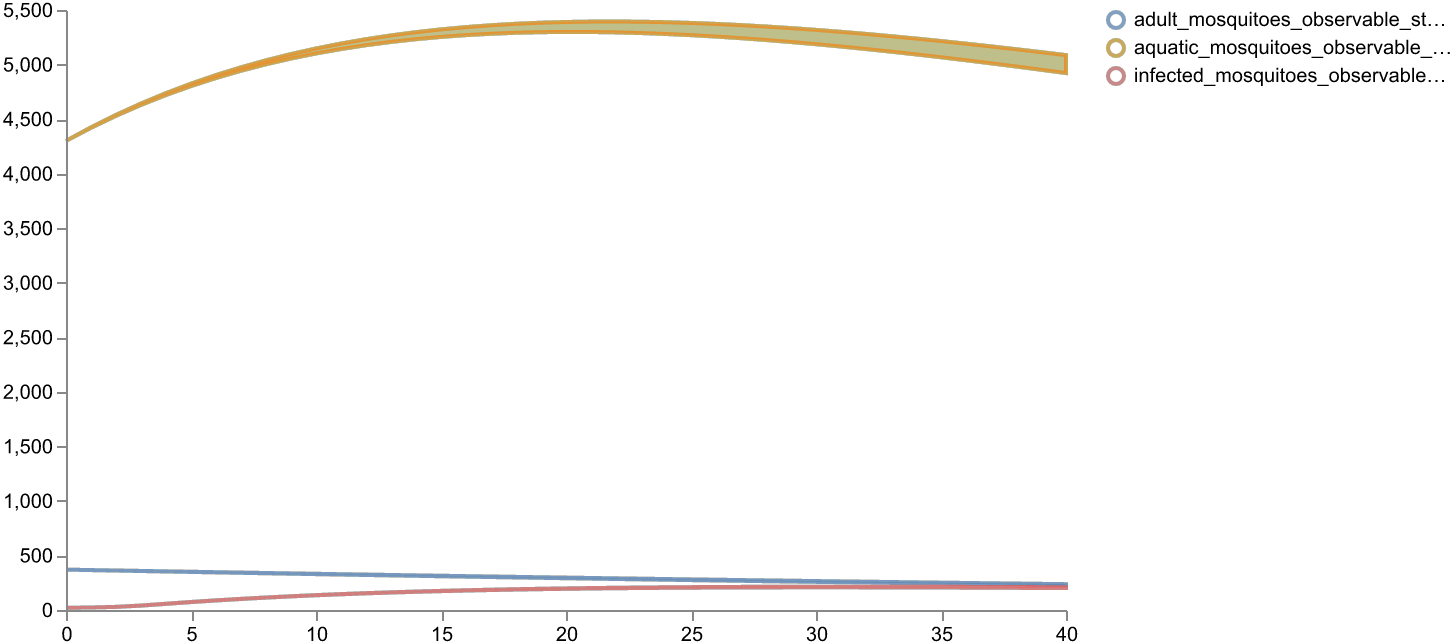

In [11]:
# Plot results for mosquito states
schema = plots.trajectories(opt_intervention_result1["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Perform optimization for increase in mosquito death rate from insecticide

In [12]:
# Define optimization problem setup
observed_params = ["Ih_state"]
intervention_time = [torch.tensor(5.0)]
intervened_params = ["zeta"]
current_param_value = 0.003
initial_guess_interventions = 0.2
bounds_interventions = [[0.01], [0.9]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    start_time = intervention_time,
)

risk_bound = 6000.0
# qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1) 
qoi = lambda y: obs_max_qoi(y, observed_params) 
objfun = lambda x: x # np.sum(np.abs(current_param_values - x))

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)

Optimal policy: tensor([0.3695], dtype=torch.float64)
{'policy': tensor([0.3695], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.3694595229493386
                          x: [ 3.695e-01]
                        nit: 5
      minimization_failures: 3
                       nfev: 51
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.3694595229493386
                                   x: [ 3.695e-01]
                                nfev: 9
                               maxcv: 0.0}


### Sample with optimal interventions applied

Intervention:  {5.0: {'zeta': tensor([0.3695])}}
Risk associated with QoI: [2658.748291015625]


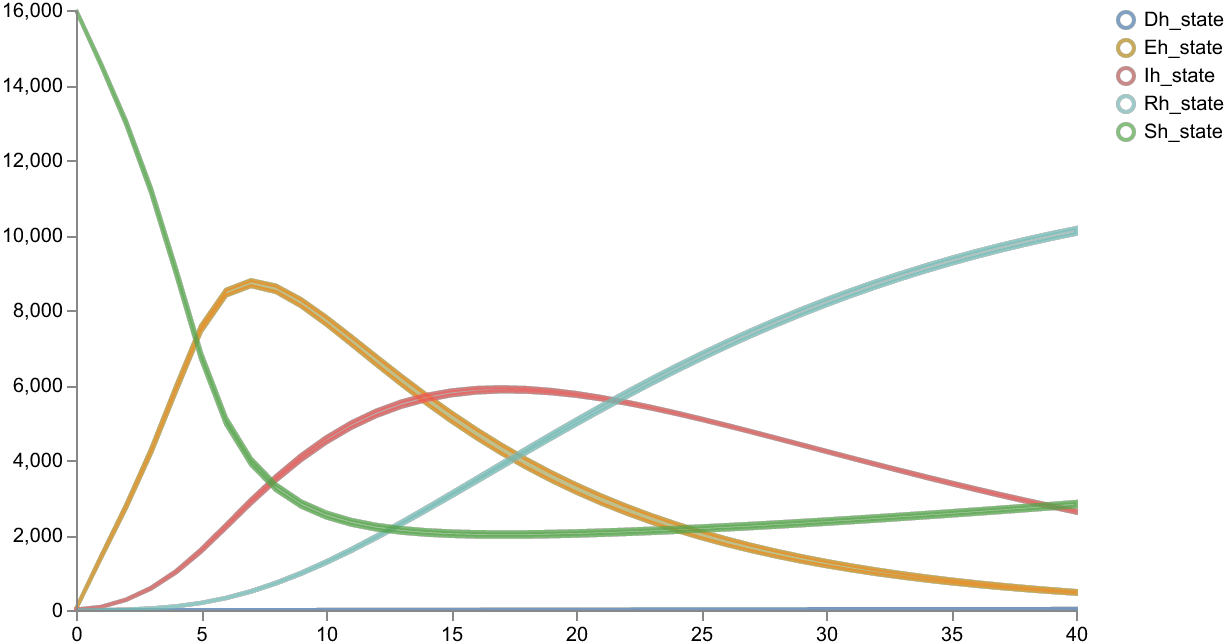

In [13]:
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

opt_intervention_result2 = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
)

# display(result1["data"])
print("Risk associated with QoI:", opt_intervention_result2["risk"][observed_params[0]]["risk"])

# Plot results for human states
schema = plots.trajectories(
    opt_intervention_result2["data"], 
    keep=".*h_state", 
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

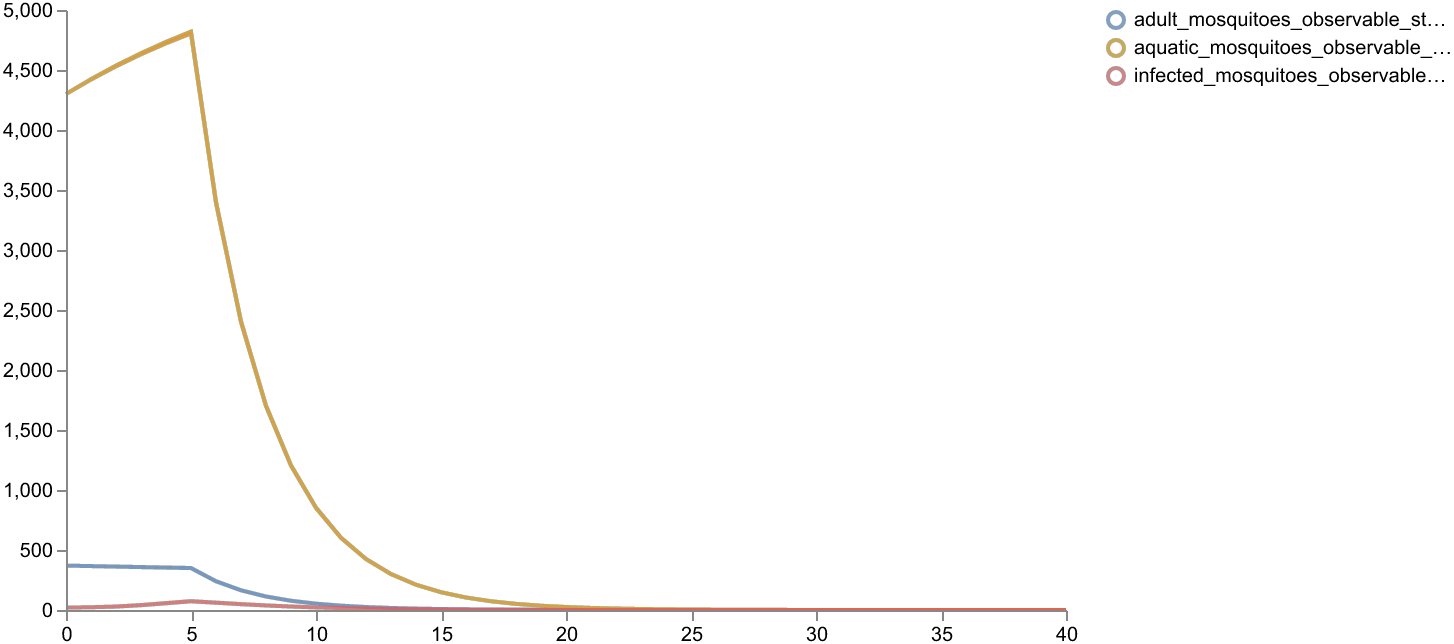

In [14]:
# Plot results for mosquito states
schema = plots.trajectories(opt_intervention_result2["data"], keep=".*mosquitoes_observable_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)